##### 辨識手寫數字
這篇教學會使用 Keras 搭配 NumPy 訓練手寫數字模型，再搭配 OpenCV KNN 演算方法 ( cv2.ml.KNearest_load )，即時辨識出手寫的阿拉伯數字。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 什麼是 KNN 演算法？ 
KNN 演算法的全名為 K Nearest Neighbor，也稱為 K-近鄰演算法，是機器學習中的一種演算法，意思是尋找 k 個最接近「某分類」的鄰居，\
透過這些鄰居來投票，以多數決定這個分類代表什麼，舉例來說，小明住的地方有 100 個鄰居，小明生了一個小孩不知道要叫什麼名字，\
於是一一詢問鄰居的意見，最後以多數鄰居的意見作為小孩的命名。

* 參考：[K-近鄰演算法](https://zh.wikipedia.org/wiki/K-%E8%BF%91%E9%82%BB%E7%AE%97%E6%B3%95)

以下圖為例，測試樣本 ( 綠色圓形 ) 在 k=3 ( 實線圓圈 ) 的狀態下，會被分配給紅色三角形 ( 因為紅色比較多 )，\
如果 k=5 ( 虛線圓圈 ) 的狀態下，會被分配給藍色正方形，何選擇一個最佳的 K 值取決於資料內容。一般情況下，\
在分類時較大的 K 值能夠減小雜訊的影響，但會使類別之間的界限變得模糊。

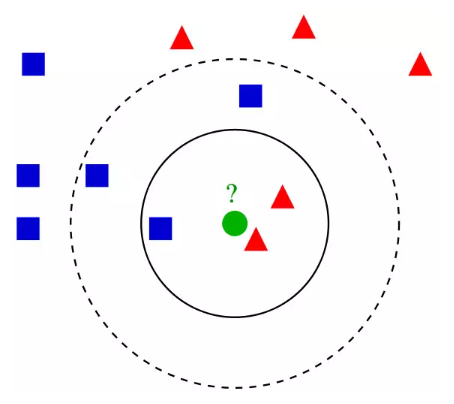

##### 安裝 Keras 
Keras 是一個開放原始碼，可以進行神經網路學習的 Python 函式庫，在 2017 年，Google TensorFlow 的核心庫加入支援 Keras 的功能，\
爾後 Keras 常常會和 TensorFlow 互相搭配使用，許多功能也都必須建構在 TensorFlow 的基礎上運作。

參考「[Jupyter 安裝 Tensorflow](https://steam.oxxostudio.tw/category/python/ai/ai-jupter-tensorflow.html)」文章，安裝 TensorFlow 後，就會一併安裝 Keras，簡單步驟說明如下 ( 如果已經安裝完成可略過此部分 )：

建立名為 tensorflow 的虛擬環境
* conda create --name tensorflow python=3.9

啟動虛擬環境
* conda activate tensorflow

安裝 Jupyter
* conda install jupyter notebook

安裝 tensorflow
* pip install tensorflow==2.5

安裝 OpenCV 和 OpenCV 進階套件
* pip install opencv-python
* pip install opencv_contrib_python

開啟 Anaconda，進入 tensorflow 虛擬環境，啟動 Jupyter

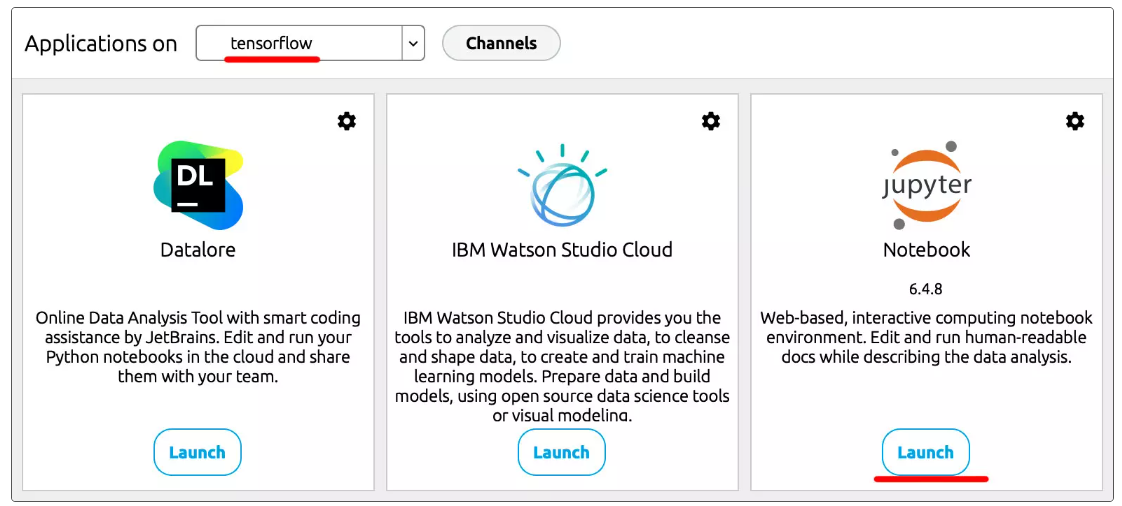

##### 訓練手寫數字模型 
訓練手寫數字模使用 keras 內建的「MNIST 手寫字符數據集」進行訓練，數據集內分成「訓練集」和「測試集」，\
訓練集有 60,000 張 28x28 像素灰度圖像，作為深度學習與訓練模型使用，測試集內有 10,000 同規格圖像，\
作為測試訓練模型使用，訓練後可以辨識手寫數字 0～9，下圖為訓練集的其中一部份手寫數字影像。

* 參考：[MNIST 手寫字符數據集](https://keras.io/zh/datasets/#mnist)

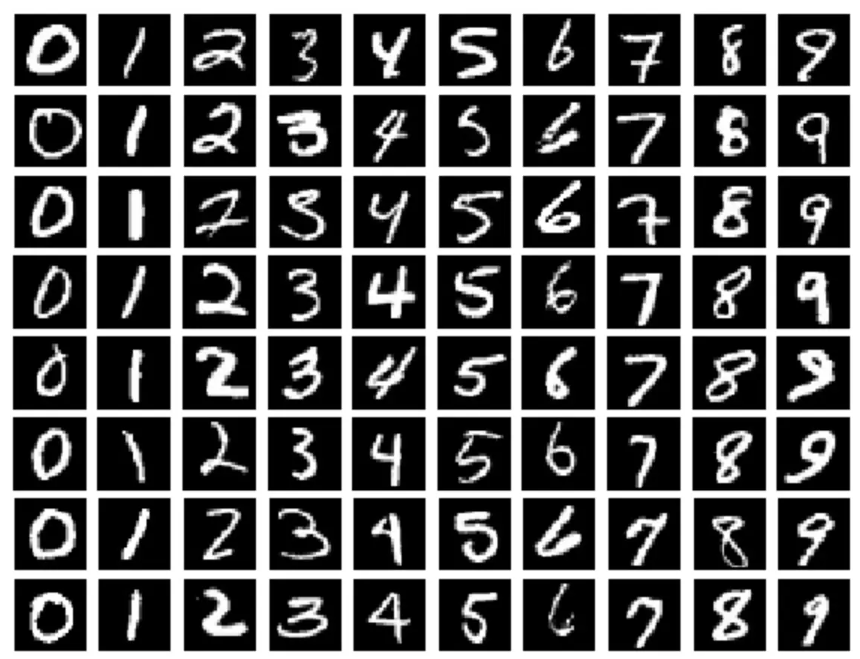

下方的程式碼執行後會進行模型訓練，訓練後會將模型儲存為 mnist_knn.xml ( 檔案大小約 200～250 MB )，\
儲存後會使用測試集進行測試，測試過程需要耗費幾分鐘的時間 ( 範例的測試結果準確度為 96.88% )，\
如果不想測試也可移除該部分程式碼，直接訓練與儲存模型。

In [ ]:
import cv2
import numpy as np
from keras.datasets import mnist
from keras import utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()  # 載入訓練集

# 訓練集資料
x_train = x_train.reshape(x_train.shape[0],-1)  # 轉換資料形狀
x_train = x_train.astype('float32')/255         # 轉換資料型別
y_train = y_train.astype(np.float32)

# 測試集資料
x_test = x_test.reshape(x_test.shape[0],-1)     # 轉換資料形狀
x_test = x_test.astype('float32')/255           # 轉換資料型別
y_test = y_test.astype(np.float32)

knn=cv2.ml.KNearest_create()                    # 建立 KNN 訓練方法
knn.setDefaultK(5)                              # 參數設定
knn.setIsClassifier(True)

print('training...')
knn.train(x_train, cv2.ml.ROW_SAMPLE, y_train)  # 開始訓練
knn.save('mnist_knn.xml')                       # 儲存訓練模型
print('ok')

print('testing...')
test_pre = knn.predict(x_test)                  # 讀取測試集並進行辨識
test_ret = test_pre[1]
test_ret = test_ret.reshape(-1,)
test_sum = (test_ret == y_test)
acc = test_sum.mean()                           # 得到準確率
print(acc)

##### 根據模型，辨識手寫數字 
已經訓練好 xml 模型檔後，就可以開始進行辨識，下方的程式碼會先取出一個正方形的區域，\
將這個區域的像素做二值化黑白的轉換 ( 因為手寫字通常是白底黑字，要轉換成黑底白字 )，\
轉換後將尺寸縮小到 28x28 進行辨識，就能得到手寫字的辨識結果，\
同時也會將辨識的影像顯示在原本影像的右上角。

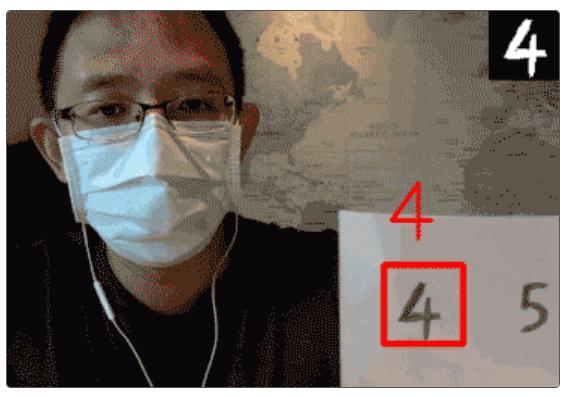

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)                     # 啟用攝影鏡頭
print('loading...')
knn = cv2.ml.KNearest_load('mnist_knn.xml')   # 載入模型
print('start...')
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    img = cv2.resize(img,(540,300))          # 改變影像尺寸，加快處理效率
    x, y, w, h = 400, 200, 60, 60            # 定義擷取數字的區域位置和大小
    img_num = img.copy()                     # 複製一個影像作為辨識使用
    img_num = img_num[y:y+h, x:x+w]          # 擷取辨識的區域

    img_num = cv2.cvtColor(img_num, cv2.COLOR_BGR2GRAY)    # 顏色轉成灰階
    # 針對白色文字，做二值化黑白轉換，轉成黑底白字
    ret, img_num = cv2.threshold(img_num, 127, 255, cv2.THRESH_BINARY_INV)
    output = cv2.cvtColor(img_num, cv2.COLOR_GRAY2BGR)     # 顏色轉成彩色
    img[0:60, 480:540] = output                            # 將轉換後的影像顯示在畫面右上角

    img_num = cv2.resize(img_num,(28,28))   # 縮小成 28x28，和訓練模型對照
    img_num = img_num.astype(np.float32)    # 轉換格式
    img_num = img_num.reshape(-1,)          # 轉換成辨識使用的格式
    img_num = img_num.reshape(1,-1)         # 轉換成辨識使用的格式
    img_num = img_num/255                   # 轉換成辨識使用的格式
    img_pre = knn.predict(img_num)          # 進行辨識
    num = str(int(img_pre[1][0][0]))        # 取得辨識結果

    text = num                              # 印出的文字內容
    org = (x,y-20)                          # 印出的文字位置
    fontFace = cv2.FONT_HERSHEY_SIMPLEX     # 印出的文字字體
    fontScale = 2                           # 印出的文字大小
    color = (0,0,255)                       # 印出的文字顏色
    thickness = 2                           # 印出的文字邊框粗細
    lineType = cv2.LINE_AA                  # 印出的文字邊框樣式
    cv2.putText(img, text, org, fontFace, fontScale, color, thickness, lineType) # 印出文字

    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)  # 標記辨識的區域
    cv2.imshow('oxxostudio', img)
    if cv2.waitKey(50) == ord('q'):
        break     # 按下 q 鍵停止
cap.release()
cv2.destroyAllWindows()